In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Jun 12 17:00:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2020 = db.rm_patent_cn_2020
    db_rm_us_2020 = db.rm_patent_us_2020
    db_rm_de_2020 = db.rm_patent_de_2020

    
except errors.ConnectionFailure as err:
    print(err)

# 2020

## Company數量

In [6]:
data_assignee = db_rm_de_2020.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2020.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2020.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
53,Qualcomm Inc,1907
57,Samsung Electronics Co Ltd,796
40,Intel Corp,558
36,Huawei Technologies Co Ltd,530
43,LG Electronics Inc,354
41,International Business Machines Corp,225
6,Apple Inc,195
60,Shanghai Langbo Communication Technology Co Ltd,182
46,Micron Technology Inc,154
1,AT&T Intellectual Property I LP,147


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [13]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Qualcomm Inc,1907,7.553287
1,Samsung Electronics Co Ltd,796,6.679599
2,Intel Corp,558,6.324359
3,Huawei Technologies Co Ltd,530,6.272877
4,LG Electronics Inc,354,5.869297
5,International Business Machines Corp,225,5.416100
6,Apple Inc,195,5.273000
7,Shanghai Langbo Communication Technology Co Ltd,182,5.204007
8,Micron Technology Inc,154,5.036953
9,AT&T Intellectual Property I LP,147,4.990433


In [14]:
com_ls = list(com_df.company)

## Data

In [15]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2020.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2020.csv")

In [16]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BG,BR,CA,CH,CL,CN,...,PL,PT,RU,SE,SG,TN,TR,TW,US,ZA
22,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.0,0.0
185,Apple Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,52.0,0.0
831,Cisco Technology Inc,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.0
1778,Huawei Technologies Co Ltd,1.0,0.0,11.0,0.0,36.0,10.0,0.0,0.0,509.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,195.0,1.0
1946,Intel Corp,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,174.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,14.0,490.0,0.0


## Similarity計算

### Country

- 換成機率  

In [17]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [18]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BG,BR,CA,CH,CL,CN,CO,...,PL,PT,RU,SE,SG,TN,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.0,0.013462,0.0,0.010536,0.005268,0.0,0.000585,0.151010,0.001756,...,0.0,0.0,0.000585,0.0,0.028973,0.000293,0.0,0.106819,0.549898,0.000000
Samsung Electronics Co Ltd,0.000000,0.0,0.001759,0.0,0.000000,0.000440,0.0,0.000000,0.203166,0.000000,...,0.0,0.0,0.000000,0.0,0.003958,0.000000,0.0,0.008355,0.346966,0.000000
Intel Corp,0.000000,0.0,0.003055,0.0,0.005092,0.000000,0.0,0.000000,0.177189,0.000000,...,0.0,0.0,0.000000,0.0,0.002037,0.000000,0.0,0.014257,0.498982,0.000000
Huawei Technologies Co Ltd,0.001011,0.0,0.011122,0.0,0.036400,0.010111,0.0,0.000000,0.514661,0.000000,...,0.0,0.0,0.007078,0.0,0.000000,0.000000,0.0,0.000000,0.197169,0.001011
LG Electronics Inc,0.000000,0.0,0.003989,0.0,0.001330,0.002660,0.0,0.000000,0.148936,0.000000,...,0.0,0.0,0.000000,0.0,0.001330,0.000000,0.0,0.003989,0.398936,0.000000


In [19]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [20]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [21]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [22]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [23]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

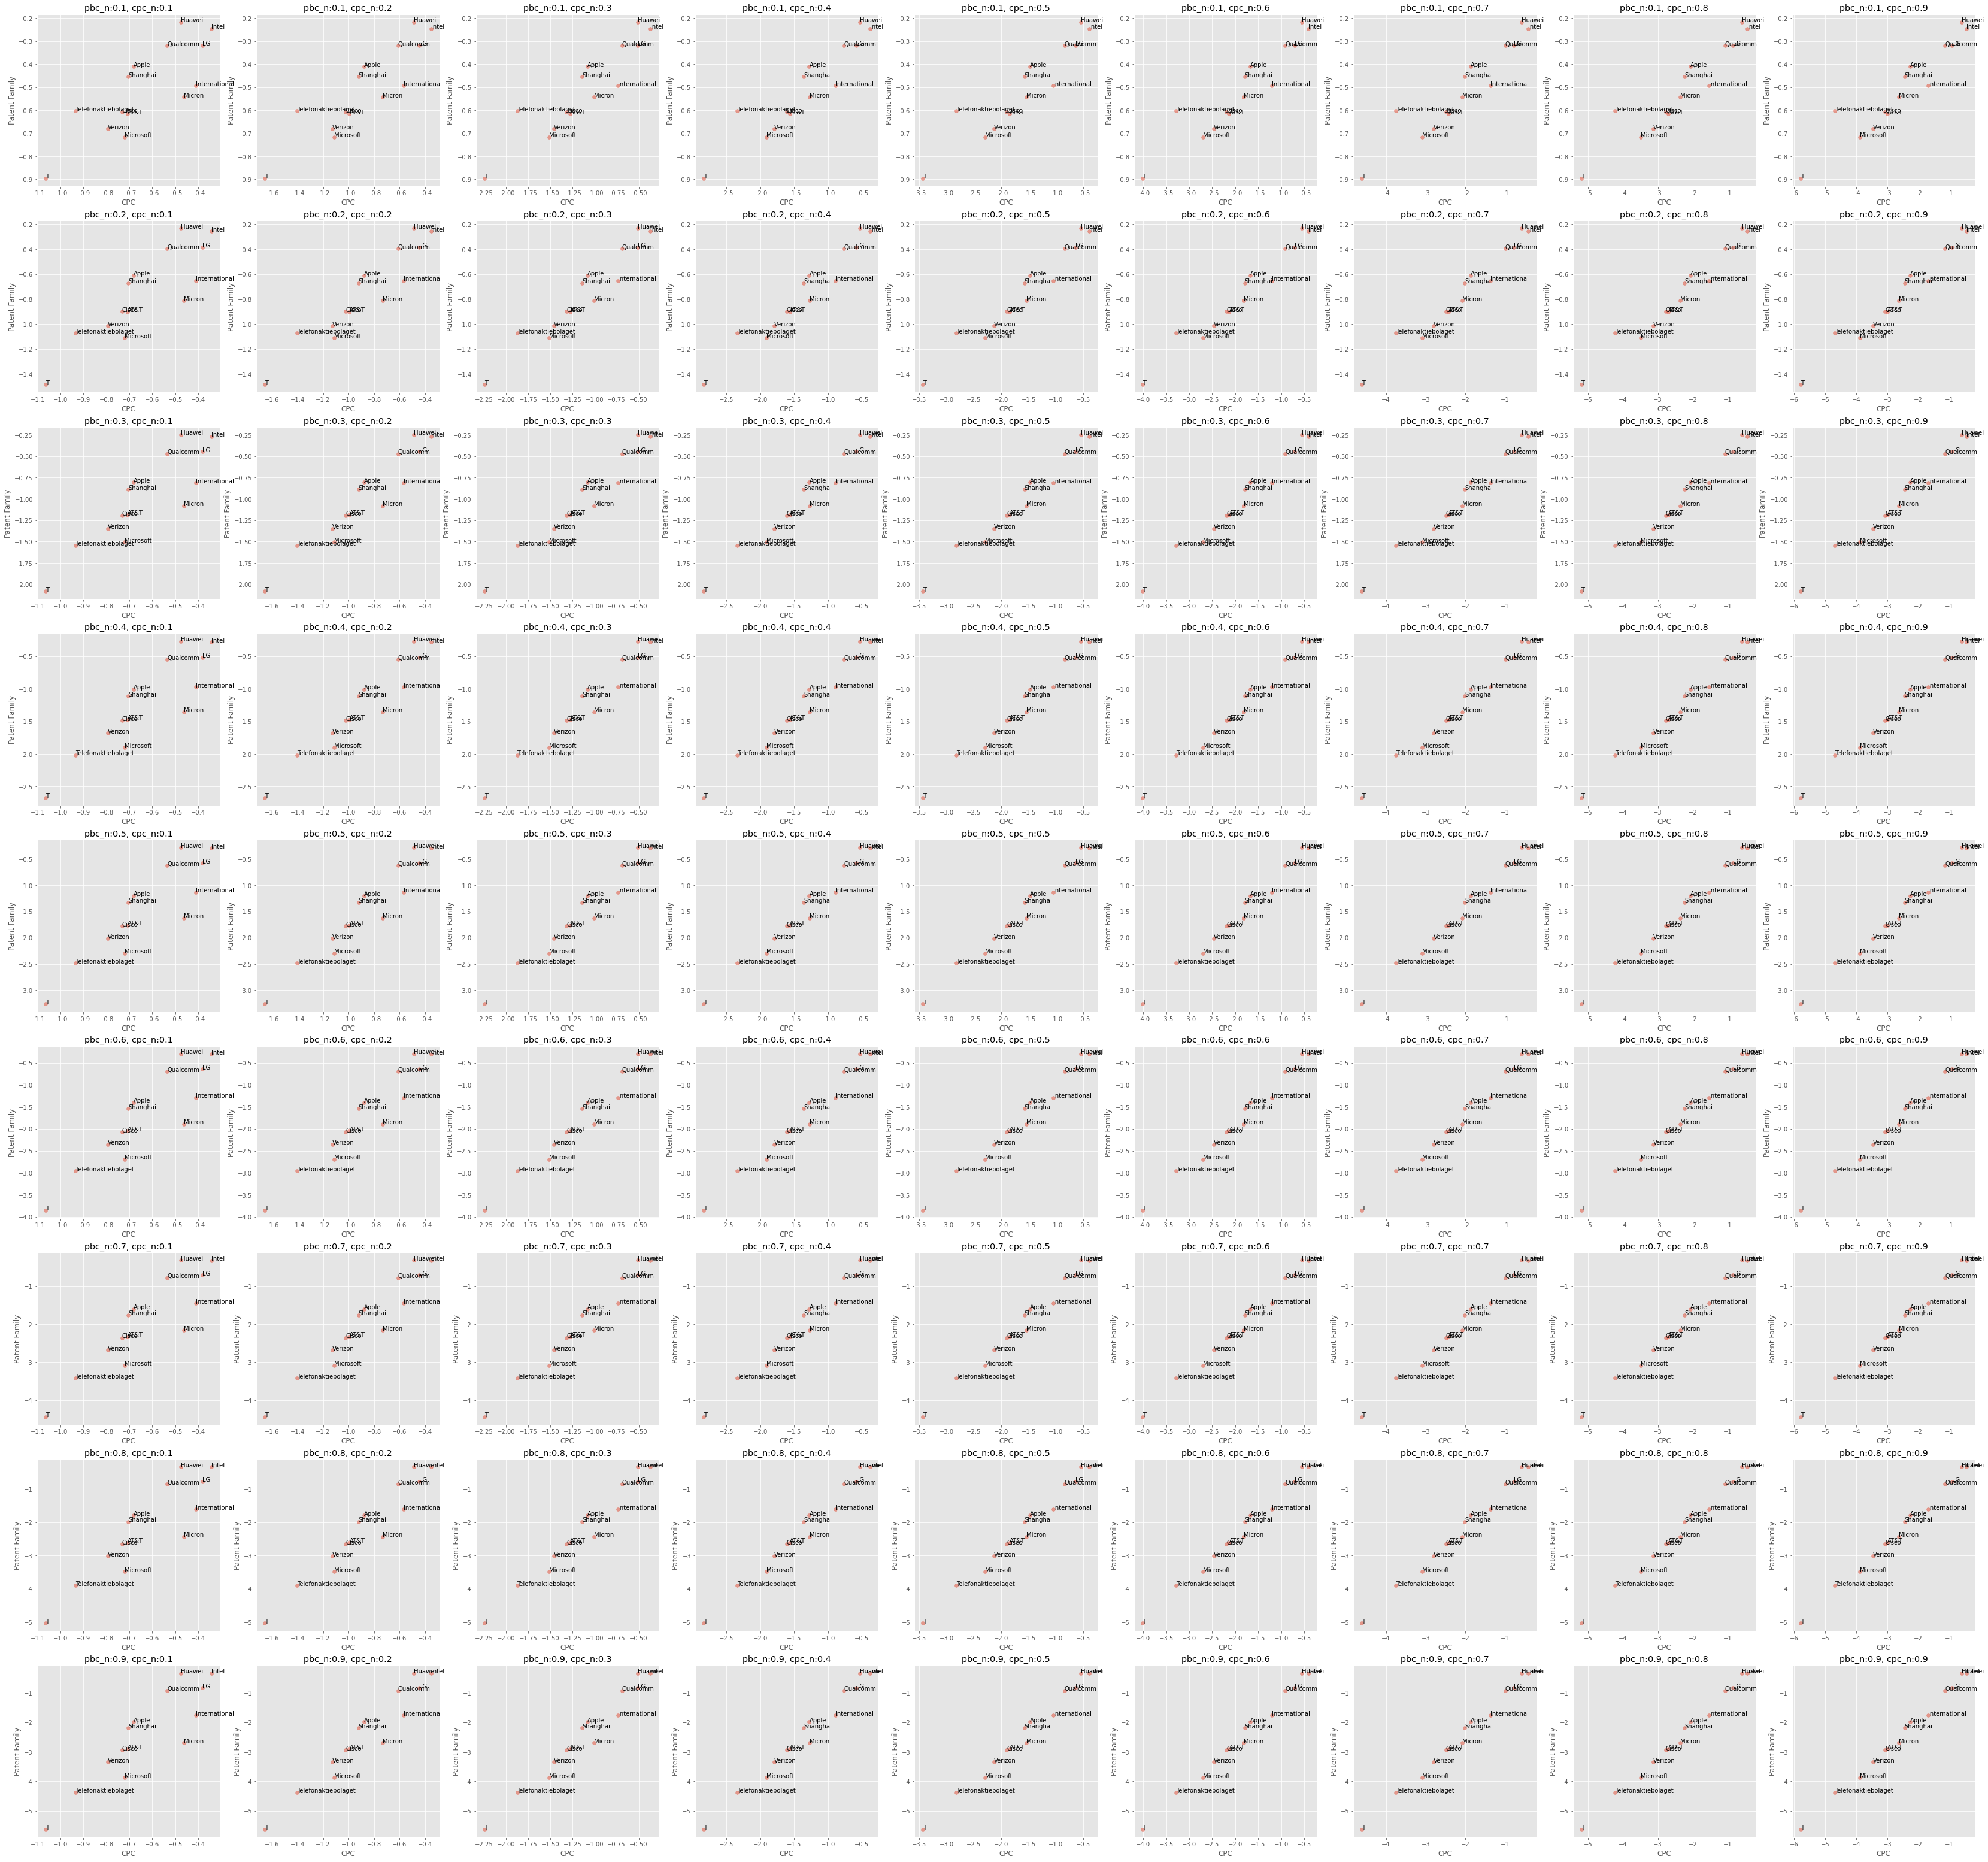

In [24]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2020_1.png'.format(pbc_n))

In [25]:
c_df

,cpc,country
company,,
Qualcomm Inc,1.146041,0.929921
Intel Corp,0.443047,0.346449
Huawei Technologies Co Ltd,0.607202,0.349214
LG Electronics Inc,0.907785,0.843609
International Business Machines Corp,1.689084,1.770651
Apple Inc,2.264689,1.993888
Shanghai Langbo Communication Technology Co Ltd,2.446746,2.197181
Micron Technology Inc,2.622438,2.701302
AT&T Intellectual Property I LP,2.991261,2.899408


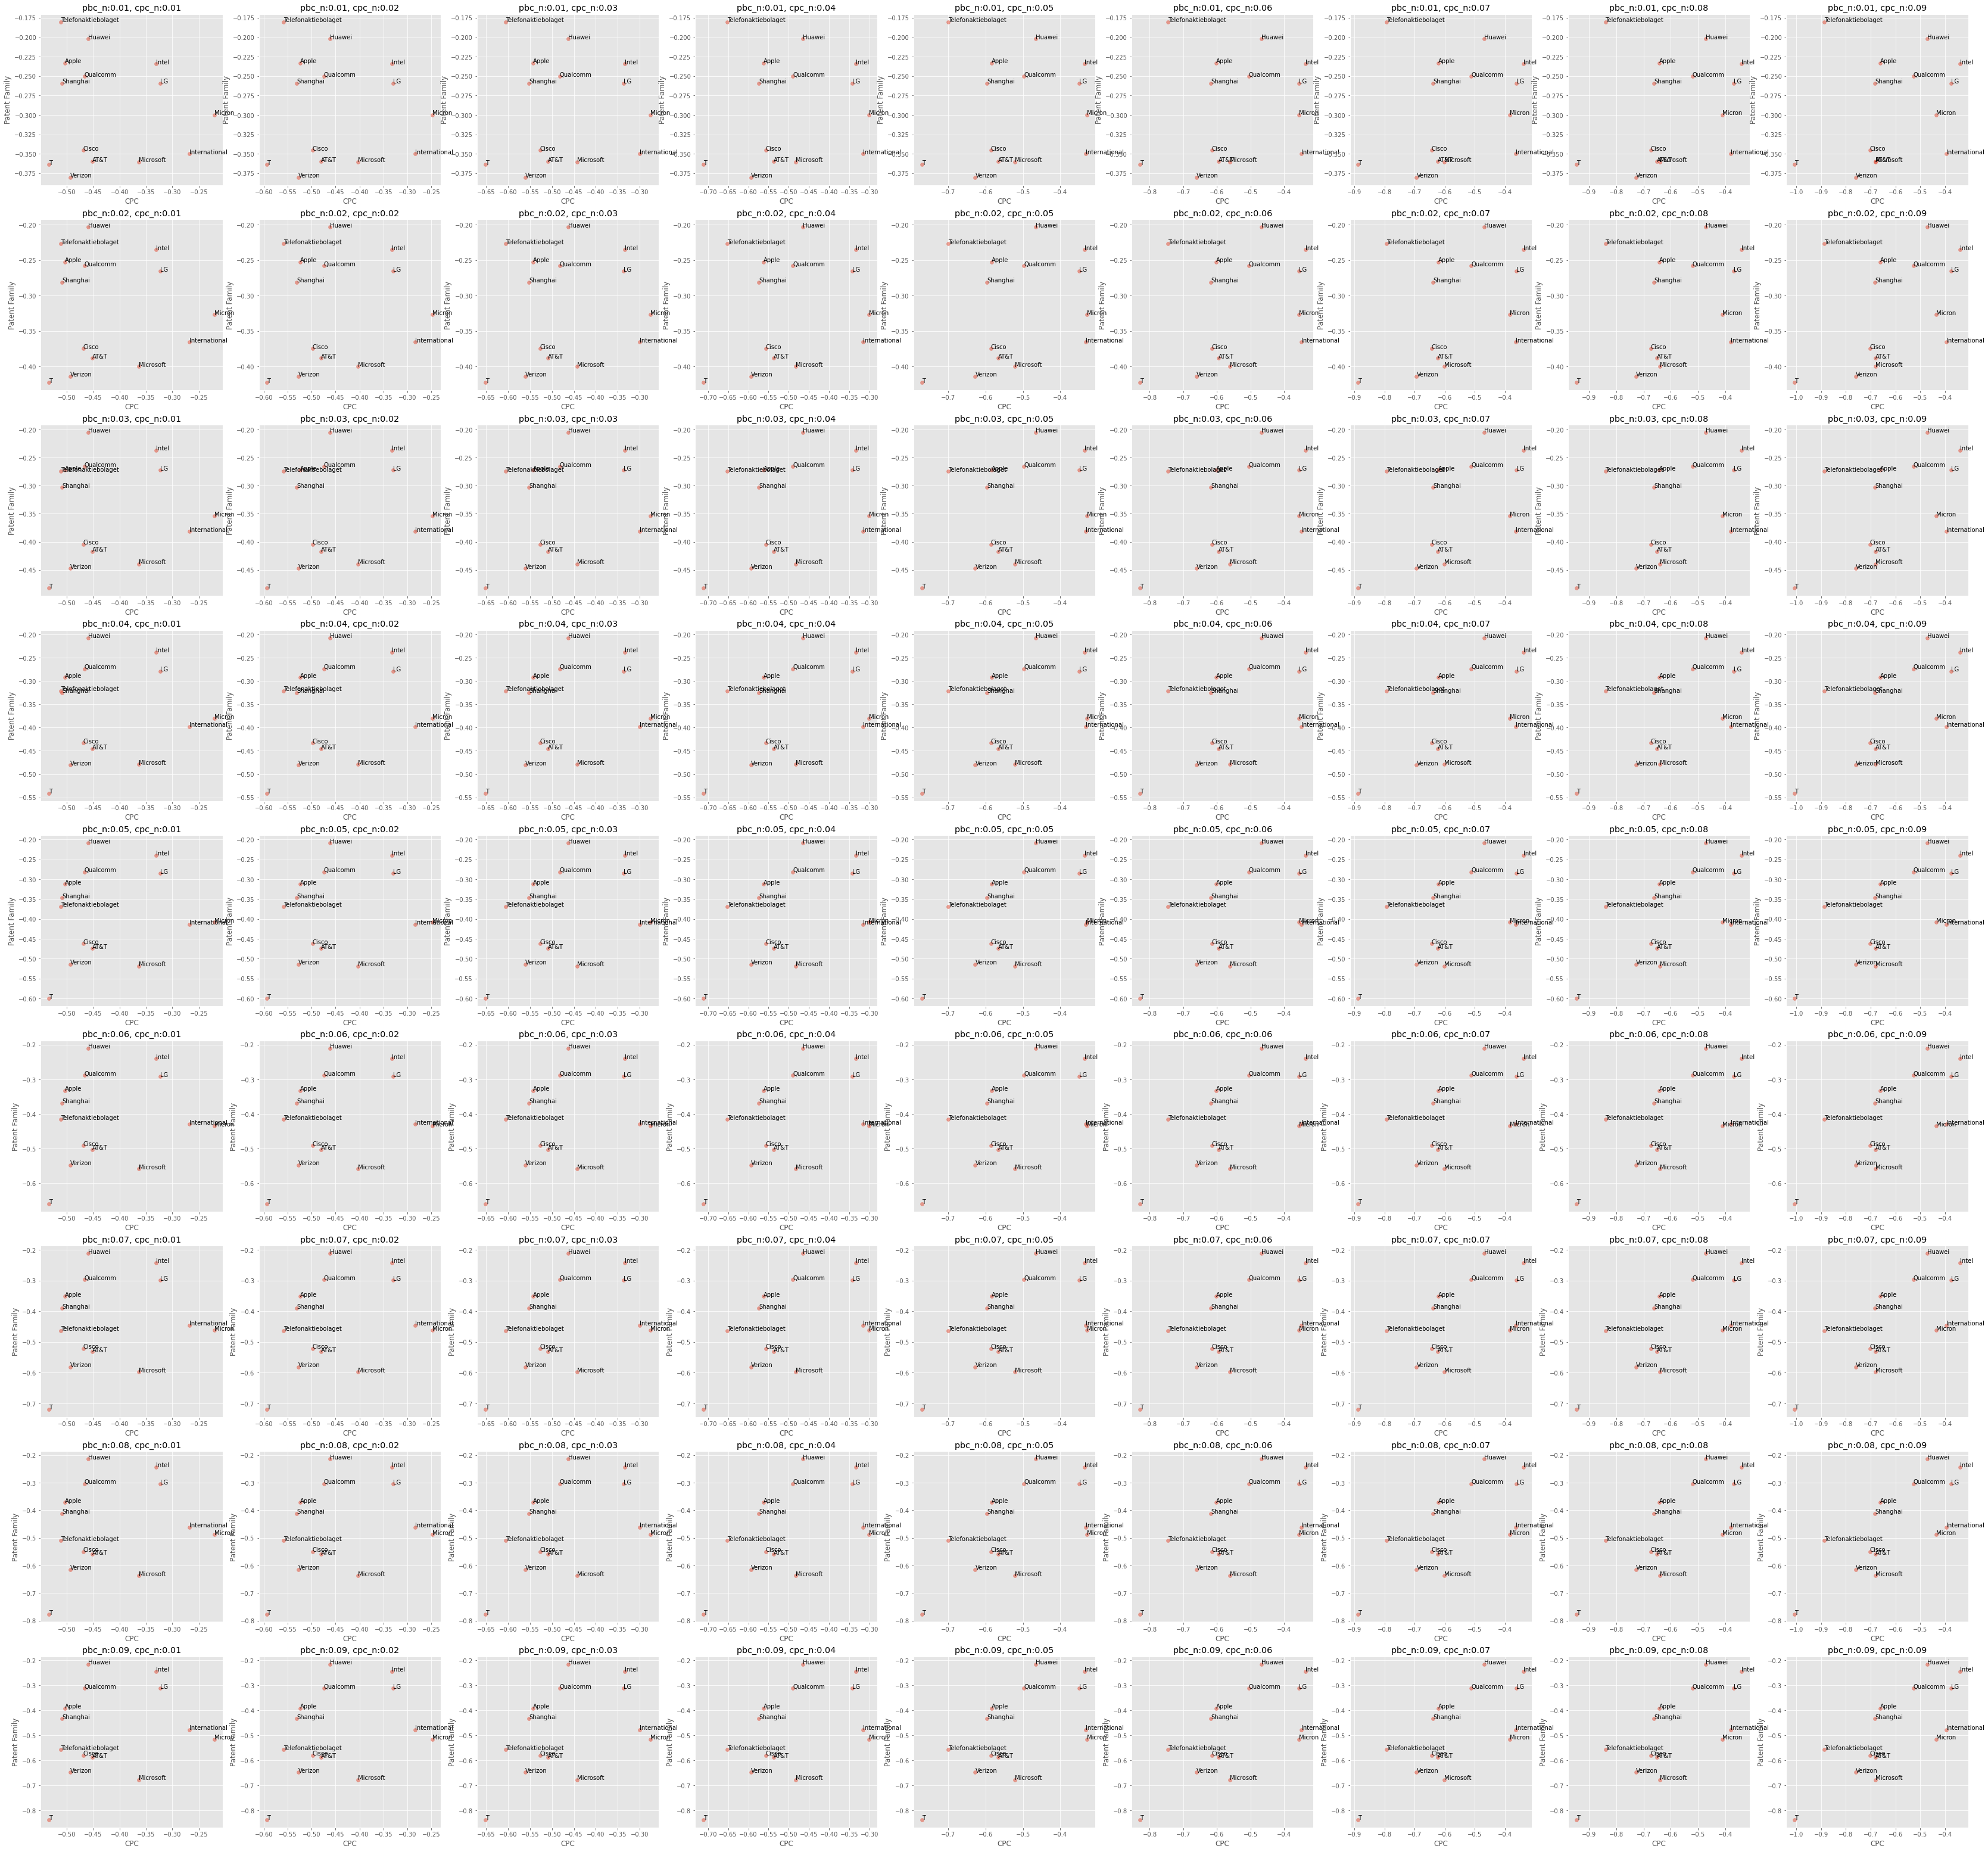

In [26]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2020_2.png'.format(pbc_n))

In [27]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.527744,0.311624
Intel Corp,0.340829,0.244230
Huawei Technologies Co Ltd,0.473209,0.215221
LG Electronics Inc,0.375948,0.311771
International Business Machines Corp,0.395977,0.477544
Apple Inc,0.662086,0.391285
Shanghai Langbo Communication Technology Co Ltd,0.683074,0.433509
Micron Technology Inc,0.436825,0.515689
AT&T Intellectual Property I LP,0.680101,0.588248


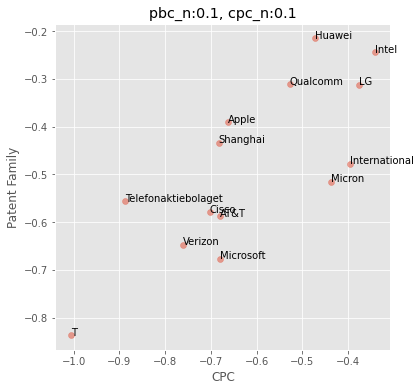

In [39]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [58]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [62]:
competitor_ls

[1, 1, 1, 1, 1, 1, 2, 1, 4, 4, 4, 4, 4, 4]

In [60]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.527744,0.311624
Intel Corp,0.340829,0.244230
Huawei Technologies Co Ltd,0.473209,0.215221
LG Electronics Inc,0.375948,0.311771
International Business Machines Corp,0.395977,0.477544
Apple Inc,0.662086,0.391285
Shanghai Langbo Communication Technology Co Ltd,0.683074,0.433509
Micron Technology Inc,0.436825,0.515689
AT&T Intellectual Property I LP,0.680101,0.588248
